## IMPORTS


In [ ]:
# imports

import sys
import re
import math
import requests
import xml.etree.ElementTree as ET
import pandas as pd
import operator
from math import sqrt
from statistics import mean
from scipy.sparse import csr_matrix


import spacy
nlp = spacy.load("en_core_web_sm")

import nltk
from nltk import stem  
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import collections
from collections import Counter
import itertools
from itertools import islice
from itertools import chain
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np 
from numpy import mean
from numpy import std

import sklearn
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.models import Sequential
from keras import layers

import random
seed_value = 1
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# nltk downloads
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## LOAD AND EXTRACT THE DATA

In [ ]:
# function to load data from xml file and return total no of reviews,review text,aspect term and aspect term polarity
def processXML(file):

  # get root
  root = ET.parse(file).getroot()

  id = []
  term = {}     # Review wise aspect term
  polarity = {} # Polarities for a review
  review_text = []

  for item in root.findall('sentence'):    
    id_val = item.get('id')
    id.append(id_val)

  total_no_reviews = len(id) 
 
  #  <review text>
  for i in range(0,total_no_reviews):
    review_text.append(root[i][0].text)

  #  <aspect term>
  for i in range (0, total_no_reviews):
    aspect_terms = root[i][1]

    # get term and polarity
    for item in aspect_terms.findall('aspectTerm'):
          term_val = item.get('term')
          polarity_val = item.get('polarity')
        
          if i not in term:
            term[i] = [term_val]
            polarity[i] = [polarity_val]
            
          else:
            term[i].append( term_val)
            polarity[i] .append(polarity_val)
  
  return total_no_reviews,review_text,term,polarity;

In [ ]:
# load and extract training data
total_no_reviews,review_text,term,polarity = processXML('Restaurants_Train.xml')

print("Total no, of reviews: ",total_no_reviews)
print("Reviews containing aspect term: ", len(term))
print("Some reviews: ",review_text[0:5])

Total no, of reviews:  3041
Reviews containing aspect term:  2021
Some reviews:  ['But the staff was so horrible to us.', "To be completely fair, the only redeeming factor was the food, which was above average, but couldn't make up for all the other deficiencies of Teodora.", "The food is uniformly exceptional, with a very capable kitchen which will proudly whip up whatever you feel like eating, whether it's on the menu or not.", 'Where Gabriela personaly greets you and recommends you what to eat.', "For those that go once and don't enjoy it, all I can say is that they just don't get it."]


In [ ]:
# load and extract testing data
total_no_reviews_test,review_text_test,term_test,polarity_test = processXML('Restaurants_Test_Gold.xml')

print("Total no, of reviews: ",total_no_reviews_test)
print("Reviews containing aspect term: ", len(term_test))
print("Some reviews: ",review_text_test[0:5])

Total no, of reviews:  800
Reviews containing aspect term:  606
Some reviews:  ['The bread is top notch as well.', 'I have to say they have one of the fastest delivery times in the city.', 'Food is always fresh and hot- ready to eat!', 'Did I mention that the coffee is OUTSTANDING?', 'Certainly not the best sushi in New York, however, it is always fresh, and the place is very clean, sterile.']


In [ ]:
# function to return only unique words in a sentence
def unique_list(line):
  
    ulist = []
    [ulist.append(x) for x in line if x not in ulist]
    return ulist

In [ ]:
# function to extract relevant info with dependency parsing and return a dict of text and polarity for a review
def getDictData(term, review_text, polarity): 

  index_list = []    # store index of review 
  descript_and_polarity = {} # dict to store the final description and its polarity

  for key,val in term.items():
    index_list.append(key)

  for i in index_list: # for each index

    review = review_text[i]
    aspect_term_list = term[i]
    polar_list = polarity[i]
    doc = nlp(review)        # spacy
    
    for k,item in enumerate(aspect_term_list):  
      single_term = len(item.split())      # get a single aspect terms in a review

      if  single_term > 1:                 # if aspect term contains more than one word, keep the first word
        item_ = item.split(' ', 1)[0]
        aspect_term_list[k] = item_       # change the orginal term in the list

    j = 0
    word_type = []
    description = ' '
    descript_dict = {}

    for token in doc:                       # for each word in review
        if token.text in aspect_term_list:  # if word is an aspect term

            aspect_item = token.text
            head = token.head

            head_child = head.children     # get all child text of head
            token_child = token.children   # get all child text of token

            for child_ in  token.children:
              description = description + " " + str(child_) # add child text of token to description
            
            for child in head_child:
              child = str(child)

              if j not in  descript_dict:
                 descript_dict[j] = [child] # store child text in a dict as list
              else:
                 descript_dict[j].append(child)

            descript_dict[j].append(description)  # store child text of both token and head for an aspect term

            j+=1 
            description = ' '   

    descript_joined = []

    for key,val in  descript_dict.items(): # combine the words stored in list to form a single text sentence
      value = ' '.join(val)
      value = ' '.join(unique_list(value.split())) # remove repeated words
      descript_joined.append(value) 

    for key,val in zip(polar_list, descript_joined): 
       descript_and_polarity[val] = key   # store description and polarity in a dict

  return descript_and_polarity

In [ ]:
all_data_train = getDictData(term,review_text,polarity)
print(len(all_data_train)) 

all_data_test = getDictData(term_test,review_text_test,polarity_test)
len(all_data_test) 

3327


1057

In [ ]:
# training dataframe
df_train = pd.DataFrame(list(all_data_train.items()),columns = ['text','sentiment']) 
print("Training data shape: ",df_train.shape) 

# testing dataframe
df_test = pd.DataFrame(list(all_data_test.items()),columns = ['text','sentiment']) 
print("Testing data shape: ", df_test.shape)

Training data shape:  (3327, 2)
Testing data shape:  (1057, 2)


In [ ]:
df_train = df_train[df_train.sentiment != "conflict"]
df_test = df_test[df_test.sentiment != "conflict"]

print("Training data shape: ",df_train.shape) 
print("Testing data shape: ", df_test.shape)

Training data shape:  (3239, 2)
Testing data shape:  (1044, 2)


In [ ]:
df_train[0:10]

,text,sentiment
0,But staff horrible . the,negative
1,"be , factor food but make . the was",positive
2,"food exceptional , with 's . The",positive
3,kitchen a capable whip,positive
4,menu the,neutral
5,"Not food , but were the outstanding",positive
6,perks great . little ',positive
7,favorite orrechiete the with,positive
8,( usually waiters enough the,positive
9,to dish in the,neutral


In [ ]:
df_test[0:10]

,text,sentiment
0,bread notch well . The,positive
1,the fastest delivery in,positive
2,Food always fresh and hot- !,positive
3,that coffee OUTSTANDING the,positive
5,"place clean , sterile . the",positive
6,I people at the,positive
7,decent Japanese,positive
8,"BEST spicy tuna , salad .",positive
9,great asian,positive
10,the rose ( on ),positive


## PREPROCESS THE DATA

In [ ]:
# function to remove puntuation
def remove_puntuation(text):
    text = [word for word in text if word.isalpha()] #  remove all puntuation and numbers
    return text 

# function to remove stop word from text
def remove_stopwords(text):
    stop_words = list(stopwords.words('english')) # store nltk stopwords
    text = [word for word in text if not word in stop_words] 
    return text 

# function to perform lemmatization
def lemmatization (text):
    lemmatizer = stem.WordNetLemmatizer() 
    text = [lemmatizer.lemmatize(token) for token in text]
    return text 


# function to perform text preprocessing (lemmatization and no stemming)
def clean_corpus(text):
    
    text = text.lower()                # lower case  
    token = word_tokenize(text)         # tokenise
  
    token = remove_stopwords(token)    # remove stopwords
    token = remove_puntuation(token)   # remove puntuation 
    token = lemmatization(token)       # lemmatize

    all_tokens = " ".join(token)       # join all tokens

    return all_tokens

In [ ]:
# preprocess training data
df_train['processed_text'] = df_train.text.apply(lambda x: clean_corpus(x))

# preprocess test data
df_test['processed_text'] = df_test.text.apply(lambda x: clean_corpus(x))

In [ ]:
# remove duplicated sentences
df_train = df_train.drop_duplicates(subset = 'processed_text' , keep = "first")
df_test = df_test.drop_duplicates(subset = 'processed_text' , keep = "first")

print("Training data shape: ",df_train.shape) 
print("Testing data shape: ", df_test.shape)

Training data shape:  (2531, 3)
Testing data shape:  (882, 3)


In [ ]:
# remove sentences with only one word, as they do not have any sentiment description term
length_text = []
length_text_t = []

for text in df_train['processed_text']:
  length_text.append(len(text.split()))

for text in df_test['processed_text']:
  length_text_t.append(len(text.split()))

df_train['len_text'] = length_text
df_test['len_text'] = length_text_t

df_train = df_train[df_train.len_text != 1]
df_test = df_test[df_test.len_text != 1]

print(df_train.shape)
print(df_test.shape)

(2136, 4)
(691, 4)


In [ ]:
df_train = df_train[['text', 'processed_text', 'len_text', 'sentiment']]
df_test = df_test[['text', 'processed_text', 'len_text', 'sentiment']]

In [ ]:
df_train[0:10]

,text,processed_text,len_text,sentiment
0,But staff horrible . the,staff horrible,2,negative
1,"be , factor food but make . the was",factor food make,3,positive
2,"food exceptional , with 's . The",food exceptional,2,positive
3,kitchen a capable whip,kitchen capable whip,3,positive
5,"Not food , but were the outstanding",food outstanding,2,positive
6,perks great . little ',perk great little,3,positive
7,favorite orrechiete the with,favorite orrechiete,2,positive
8,( usually waiters enough the,usually waiter enough,3,positive
11,"Bagels taste , gummy . The",bagel taste gummy,3,positive
12,Nevertheless food good . the itself,nevertheless food good,3,positive


In [ ]:
df_test[0:10]

,text,processed_text,len_text,sentiment
0,bread notch well . The,bread notch well,3,positive
1,the fastest delivery in,fastest delivery,2,positive
2,Food always fresh and hot- !,food always fresh,3,positive
3,that coffee OUTSTANDING the,coffee outstanding,2,positive
5,"place clean , sterile . the",place clean sterile,3,positive
7,decent Japanese,decent japanese,2,positive
8,"BEST spicy tuna , salad .",best spicy tuna salad,4,positive
9,great asian,great asian,2,positive
12,"I drinks is the , martini",drink martini,2,positive
13,"esp lychee , and",esp lychee,2,positive


In [ ]:
# function to get word count of a dataset
def word_count(dataset):
    
    unique_words = [] 
    
    for row in dataset:
        for word in row.split(" "):
            if len(word) > 2 and word not in unique_words:
                unique_words.append(word) # Add each unique word of length > 2 to the list
            
    unique_words.sort()
    vocab = {j:i for i,j in enumerate(unique_words)} # Enumerate the list, i.e., give consecutive numbers to each item, store in a dict
    return vocab

In [ ]:
#total number of unique words in training set
unique_words_ques2 = word_count(df_train['processed_text'])
print("Number of unique words in processed training text: ",len(unique_words_ques2))  

unique_words_ = word_count(df_train['text'])
print("Number of unique words in original training text: ",len(unique_words_))   

Number of unique words in processed training text:  1521
Number of unique words in original training text:  1931


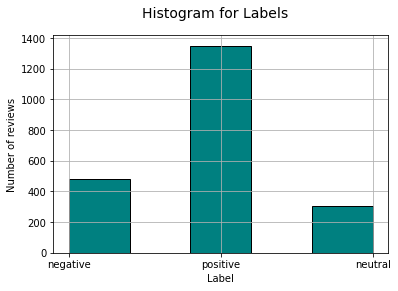

In [ ]:
# plot distribution of label in training data
df_train['sentiment'].hist(edgecolor = 'black',bins=5,facecolor = 'teal')
plt.suptitle("Histogram for Labels",size = 14)
plt.xlabel("Label")
plt.ylabel("Number of reviews")
plt.show()

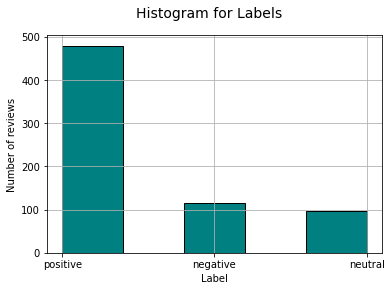

In [ ]:
# plot distribution of label in test data
df_test['sentiment'].hist(edgecolor = 'black',bins=5,facecolor = 'teal')
plt.suptitle("Histogram for Labels",size = 14)
plt.xlabel("Label")
plt.ylabel("Number of reviews")
plt.show()

## TFIDF AND SOME CLASSIFIERS (Logistic Regression, Multinomial Naive Bayes & Support Vector Classifier)

In [ ]:
y_test = df_test['sentiment']

- TFIDF

In [ ]:
# TF-IDF transformation
vectorizer = TfidfVectorizer()
vectorizer.fit(df_train['processed_text'])

x_train_tfidf = vectorizer.transform(df_train['processed_text'])
x_test_tfidf = vectorizer.transform(df_test['processed_text'])

print(vectorizer.get_feature_names())

print("Training feature shape", x_train_tfidf.shape)
print("Testing feature shape", x_test_tfidf .shape)

['aanother', 'absolutely', 'ac', 'accomodate', 'accomodating', 'accompaniment', 'actor', 'actually', 'add', 'added', 'addition', 'additional', 'adequate', 'adopted', 'adventurous', 'advice', 'aesthetic', 'affected', 'affordable', 'afortune', 'ago', 'agreable', 'ahead', 'air', 'ala', 'alain', 'allow', 'alluring', 'almost', 'alone', 'along', 'also', 'although', 'always', 'amanzing', 'amazin', 'amazing', 'ambiance', 'ambience', 'ambitious', 'american', 'americanized', 'amiable', 'amid', 'among', 'amount', 'amuse', 'angry', 'annoying', 'annual', 'another', 'antipasti', 'anything', 'anyway', 'anywhere', 'apart', 'apology', 'app', 'apparently', 'appealing', 'appetizer', 'appetizing', 'apple', 'appointment', 'apps', 'ar', 'architecture', 'area', 'around', 'arrived', 'as', 'asian', 'aside', 'ask', 'asked', 'assorted', 'assortment', 'ate', 'atlhough', 'atmosphere', 'atomosphere', 'atrocious', 'attend', 'attentive', 'attest', 'attitude', 'attract', 'attraction', 'attractive', 'au', 'aunthentic',

In [ ]:
# split training data into training and validation set
x_train, x_valid, y_train, y_valid = train_test_split(x_train_tfidf , df_train['sentiment'], test_size=0.25, random_state=42,shuffle = True)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)

(1602, 1539)
(1602,)
(534, 1539)


- GRID SEARCH

In [ ]:
# function to perform grid search for some_parameters 
def doGridSearch(model, some_parameters):

  cv = StratifiedKFold(n_splits=5, random_state=42, shuffle = True)
  search = GridSearchCV(model, some_parameters, scoring='accuracy', n_jobs=-1, cv=cv)

  result = search.fit(x_train, y_train)

  # print summary
  print('Best Score: %s' % result.best_score_)
  print('Best Hyperparameters: %s' % result.best_params_)
  print()

  means = result.cv_results_['mean_test_score']
  stds = result.cv_results_['std_test_score']

  for mean, std, params in zip(means, stds, result.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, params))

- LOGISTIC REGRESSION

In [ ]:
logisticreg =  LogisticRegression(multi_class='multinomial')

parameters = {'solver':  ['lbfgs','newton-cg' , 'sag','saga'] ,  'C': [0.01,0.1,0.5,1.0,1.5], 'tol':[0.0001,0.001, 0.01,0.1]}
doGridSearch(logisticreg, parameters)

Best Score: 0.6928855140186917
Best Hyperparameters: {'C': 1.5, 'solver': 'lbfgs', 'tol': 0.0001}

0.637 (+/-0.002) for {'C': 0.01, 'solver': 'lbfgs', 'tol': 0.0001}
0.637 (+/-0.002) for {'C': 0.01, 'solver': 'lbfgs', 'tol': 0.001}
0.637 (+/-0.002) for {'C': 0.01, 'solver': 'lbfgs', 'tol': 0.01}
0.637 (+/-0.002) for {'C': 0.01, 'solver': 'lbfgs', 'tol': 0.1}
0.637 (+/-0.002) for {'C': 0.01, 'solver': 'newton-cg', 'tol': 0.0001}
0.637 (+/-0.002) for {'C': 0.01, 'solver': 'newton-cg', 'tol': 0.001}
0.637 (+/-0.002) for {'C': 0.01, 'solver': 'newton-cg', 'tol': 0.01}
0.637 (+/-0.002) for {'C': 0.01, 'solver': 'newton-cg', 'tol': 0.1}
0.637 (+/-0.002) for {'C': 0.01, 'solver': 'sag', 'tol': 0.0001}
0.637 (+/-0.002) for {'C': 0.01, 'solver': 'sag', 'tol': 0.001}
0.637 (+/-0.002) for {'C': 0.01, 'solver': 'sag', 'tol': 0.01}
0.637 (+/-0.002) for {'C': 0.01, 'solver': 'sag', 'tol': 0.1}
0.637 (+/-0.002) for {'C': 0.01, 'solver': 'saga', 'tol': 0.0001}
0.637 (+/-0.002) for {'C': 0.01, 'solver'

In [ ]:
# Best Score: 0.6928855140186917
# Best Hyperparameters: {'C': 1.5, 'solver': 'lbfgs', 'tol': 0.0001}

- MULTINOMIAL NAIVE BAYES

In [ ]:
naivebayes  = MultinomialNB()
parameters = {'alpha': [0.001, 0.01,0.1,0.5,1.0,1.2]}
doGridSearch(naivebayes, parameters)

Best Score: 0.6810066199376947
Best Hyperparameters: {'alpha': 0.5}

0.656 (+/-0.041) for {'alpha': 0.001}
0.656 (+/-0.041) for {'alpha': 0.01}
0.671 (+/-0.036) for {'alpha': 0.1}
0.681 (+/-0.037) for {'alpha': 0.5}
0.657 (+/-0.015) for {'alpha': 1.0}
0.653 (+/-0.009) for {'alpha': 1.2}


In [ ]:
# Best Score: 0.6810066199376947
# Best Hyperparameters: {'alpha': 0.5}

- SUPPORT VECTOR CLASSIFIER

In [ ]:
svc = SVC()
parameters = {'kernel':  ['rbf', 'poly','sigmoid'] , 'C': [0.1,0.5,1.0,5,10], 'gamma': [0.0001,0.001,0.01,0.1]}
doGridSearch(svc, parameters)

Best Score: 0.690369937694704
Best Hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

0.637 (+/-0.002) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.637 (+/-0.002) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'poly'}
0.637 (+/-0.002) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.637 (+/-0.002) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.637 (+/-0.002) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}
0.637 (+/-0.002) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.637 (+/-0.002) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.637 (+/-0.002) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'poly'}
0.637 (+/-0.002) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.637 (+/-0.002) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.637 (+/-0.002) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}
0.637 (+/-0.002) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.637 (+/-0.002) for {'C': 0.5, 'gamma': 0.0001, 'kernel': 'rbf'}
0.637 (+/-0.002) for {'C': 0.5, 'gamma': 0.000

In [ ]:
# Logistic Regression
# Best Score: 0.6928855140186917
# Best Hyperparameters: {'C': 1.5, 'solver': 'lbfgs', 'tol': 0.0001}

# Mult NB
# Best Score: 0.6810066199376947
# Best Hyperparameters: {'alpha': 0.5}

# SVC
# Best Score: 0.690369937694704
# Best Hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

# Logistic Regression has best accuracy on validation set #

- Test Set Evaluation

In [ ]:
# TEST SET

model = LogisticRegression(multi_class='multinomial',C = 1.5, solver= 'lbfgs', tol =  0.0001, random_state=42) 
model.fit(x_train, y_train)
y_pred = model.predict(x_test_tfidf) #x_test_tfidf

accuracy_score(y_pred, y_test) #0.6800

0.7279305354558611

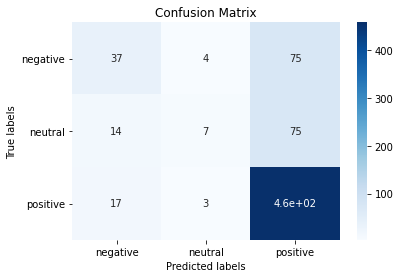

In [ ]:
# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap='Blues'); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ "negative", "neutral","positive"]);
ax.yaxis.set_ticklabels(["negative", "neutral","positive"],rotation = 0);


## EMBEDDINGS WITH NEURAL NETWORK

In [ ]:
# test label
y_test = pd.get_dummies(df_test['sentiment'])
y_test = y_test.values

# all training label
y = pd.get_dummies(df_train['sentiment'])
label = y.values
label

array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0]], dtype=uint8)

In [ ]:
print(df_train.describe())
print()
print(df_test.describe())

          len_text
count  2136.000000
mean      2.640918
std       0.852489
min       0.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       8.000000

         len_text
count  691.000000
mean     2.602026
std      0.776052
min      0.000000
25%      2.000000
50%      2.000000
75%      3.000000
max      5.000000


In [ ]:
from tensorflow.keras.preprocessing import text

x = df_train['processed_text'].values

max_features = 1500         # most freq 1500 words in the dataset would be kept
max_text_length = 8        # as  max text length = 8

# change each text into a sequence of integers, each integer being index of token in a dictionary
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))
x_tokenized = x_tokenizer.texts_to_sequences(x)
x_training_all = sequence.pad_sequences(x_tokenized,maxlen = max_text_length)#padding

x_training_all

array([[  0,   0,   0, ...,   0,  10, 174],
       [  0,   0,   0, ..., 685,   1,  85],
       [  0,   0,   0, ...,   0,   1, 437],
       ...,
       [  0,   0,   0, ..., 198, 242, 191],
       [  0,   0,   0, ..., 191, 588,  74],
       [  0,   0,   0, ...,   0,  71,  65]], dtype=int32)

In [ ]:
#tokenise and pad the text 
x_test_tokenized = x_tokenizer.texts_to_sequences(df_test['processed_text'].values)
x_testing = sequence.pad_sequences(x_test_tokenized,maxlen = max_text_length) 

x_testing

array([[   0,    0,    0, ...,   95,  909,   36],
       [   0,    0,    0, ...,    0, 1017,   79],
       [   0,    0,    0, ...,    1,   15,   21],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,   39],
       [   0,    0,    0, ...,    0,    0,  264]], dtype=int32)

#### Embedding

In [ ]:
# code to download glove data
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-06-10 19:57:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-10 19:57:05--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-10 19:57:06--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# open glove and store word embeddings
embedding_dim = 100
embeddings_index = dict()

f = open('glove.6B.100d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype = 'float32') #store all excepy val[0]
    embeddings_index[word] = coefs                  #populate embedding dict
    
f.close()

print(f'Found {len(embeddings_index)} word vectors') 

Found 400000 word vectors


In [ ]:
# prepare embedding_matrix

embedding_matrix = np.zeros((max_features,embedding_dim))

for word,index in x_tokenizer.word_index.items():
    
    if index> max_features -1: #bounding by max feat
        break
    else:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(1500, 100)

In [ ]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.16486     0.91996998  0.22736999 ... -0.067904    1.5072
   0.60889   ]
 [-0.4224     -0.13313    -0.41418001 ... -0.070558    0.12285
   0.43399999]
 ...
 [ 0.75694001  0.033857    0.37807    ...  0.26293999  0.60535997
   0.62142998]
 [-0.34031999  0.16266     0.12526    ... -0.56076998 -0.41714001
   0.43031999]
 [ 0.066709    0.27447999  0.81423998 ...  0.50615001  0.50641
   0.025595  ]]


In [ ]:
# split data into training and vslidation set
x_train, x_valid, y_train, y_valid = train_test_split(x_training_all ,label, test_size=0.2, random_state=42, shuffle = True)

print(x_train.shape)
print(y_train.shape)

print(x_valid.shape)
print(y_valid.shape)

(1708, 8)
(1708, 3)
(428, 8)
(428, 3)


In [ ]:
x_train

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,  154,   21,  264],
       [   0,    0,    0, ...,    0,  259,  173],
       ...,
       [   0,    0,    0, ...,    0,    6,  618],
       [   0,    0,    0, ...,  183, 1185,   31],
       [   0,    0,    0, ...,    0,  219, 1012]], dtype=int32)

#### Model

In [ ]:
# plot accuracy and loss curves
def plot_history(history):
    
    plt.figure(figsize=(8,5),linewidth = 7, edgecolor="whitesmoke")    
    n = len(history.history['accuracy'])
    
    plt.plot(np.arange(0,n)+1,history.history['accuracy'], color='orange',marker=".")
    plt.plot(np.arange(0,n)+1,history.history['loss'],'b',marker=".")
    
    # offset both validation curves
    plt.plot(np.arange(0,n)+ 1,history.history['val_accuracy'],'r')  
    plt.plot(np.arange(0,n)+ 1,history.history['val_loss'],'g')
    
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    
    # set vertical limit to 1
    plt.gca().set_ylim(0,1)

    plt.xlabel("Number of Epochs")
    plt.ylabel("Value")
    plt.suptitle("Learning Curve", size=16, y=0.927)
    plt.show() 

In [ ]:
#function to evaluate the model using validation data
def model_evalulate(model_name):
    
    testres = model_name.evaluate(x_valid, y_valid, verbose=0)
    
    print("Validation set")
    print('loss:', testres[0])
    print("accuracy:" ,testres[1])

#function to evaluate the model using test data
def model_evalulate_test(model_name):
    
    testres = model_name.evaluate(x_testing, y_test, verbose=0)
    
    print("Test set")
    print('loss:', testres[0])
    print("accuracy:" ,testres[1])

In [ ]:
# set some values

embedding_dim = 100
max_features = 1500   
actfn = 'relu'
optimizer_ = tf.optimizers.Adam
learningrate = 0.001
batch_size = 20

In [ ]:
# function to build the CNN model 
def model_cnn():
    
    model = Sequential()
    
    #create embedding layer
    model.add(Embedding(max_features, embedding_dim, trainable = False ,embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)))  

    # 1st dropout
    model.add(Dropout(0.4))
    
    # 1st convolutional 1-D layer
    model.add(Conv1D(32,3, padding = 'valid',activation = actfn)) #no padding
    
    #max pooling layer
    model.add(MaxPooling1D())
    
    # 2nd convolutional 1-D layer
    model.add(Conv1D(64, 3, padding = 'valid', activation = actfn))
    
    # global max pooling layer
    model.add(GlobalMaxPooling1D())
    
    # 1st dense layer
    model.add(Dense(6,activation = actfn))
    
    # 2nd dropout
    model.add(Dropout(0.4))
    
    # final dense layer
    model.add(Dense(3,activation = 'softmax')) #sigmoid
    
    # compile the model
    model.compile(loss = 'categorical_crossentropy',    
                 optimizer = optimizer_(learning_rate = 0.001),
                 metrics = ['accuracy']) 

    return model

In [ ]:
# function to build the LSTM model 
def model_lstm():
    
    model = Sequential()
    
    #create embedding layer
    model.add(Embedding(max_features, embedding_dim, trainable = False ,embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)))  

    model.add(layers.Bidirectional(layers.LSTM(20, dropout=0.5,activation='tanh')))

    model.add(Dense(10, activation='relu'))

    # final dense layer
    model.add(Dense(3,activation = 'softmax'))
    
    # compile the model
    model.compile(loss = 'categorical_crossentropy',    
                 optimizer = 'rmsprop'     ,   
                 metrics = ['accuracy']) 

    return model

In [ ]:
# function to compile and fit the model 
def model_run(actfn, n_epochs, batch_size, model):
    
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1 ,patience= 20, restore_best_weights = True ) 
    
    # fit the model
    history = model.fit(x_train,y_train,
              batch_size = batch_size,
              epochs = n_epochs,
              validation_data=(x_valid,y_valid),
              callbacks=[es] )
    
    return (history, model)

Epoch 1/100
86/86 [==============================] - 16s 19ms/step - loss: 1.0083 - accuracy: 0.4429 - val_loss: 0.8817 - val_accuracy: 0.6308
Epoch 2/100
86/86 [==============================] - 1s 7ms/step - loss: 0.8725 - accuracy: 0.6210 - val_loss: 0.8573 - val_accuracy: 0.6308
Epoch 3/100
86/86 [==============================] - 1s 7ms/step - loss: 0.8541 - accuracy: 0.6216 - val_loss: 0.8375 - val_accuracy: 0.6425
Epoch 4/100
86/86 [==============================] - 1s 6ms/step - loss: 0.8006 - accuracy: 0.6626 - val_loss: 0.8288 - val_accuracy: 0.6589
Epoch 5/100
86/86 [==============================] - 1s 6ms/step - loss: 0.7817 - accuracy: 0.6674 - val_loss: 0.7993 - val_accuracy: 0.6495
Epoch 6/100
86/86 [==============================] - 1s 6ms/step - loss: 0.7623 - accuracy: 0.6784 - val_loss: 0.8015 - val_accuracy: 0.6589
Epoch 7/100
86/86 [==============================] - 1s 6ms/step - loss: 0.7289 - accuracy: 0.6873 - val_loss: 0.8201 - val_accuracy: 0.6565
Epoch 8/100

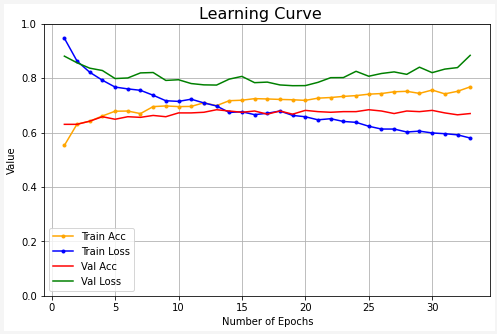


Validation set
loss: 0.7753225564956665
accuracy: 0.6845794320106506


In [ ]:
# Run LSTM model

seed_value = 2
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

history_1stm, model_1stm = model_run (actfn, 100, batch_size,  model_lstm())
plot_history(history_1stm) 

print()
model_evalulate(model_1stm)

Epoch 1/100
86/86 [==============================] - 18s 9ms/step - loss: 1.0242 - accuracy: 0.5486 - val_loss: 0.8916 - val_accuracy: 0.6308
Epoch 2/100
86/86 [==============================] - 0s 3ms/step - loss: 0.9345 - accuracy: 0.6329 - val_loss: 0.8675 - val_accuracy: 0.6308
Epoch 3/100
86/86 [==============================] - 0s 3ms/step - loss: 0.8753 - accuracy: 0.6361 - val_loss: 0.8605 - val_accuracy: 0.6379
Epoch 4/100
86/86 [==============================] - 0s 3ms/step - loss: 0.8557 - accuracy: 0.6495 - val_loss: 0.8409 - val_accuracy: 0.6425
Epoch 5/100
86/86 [==============================] - 0s 3ms/step - loss: 0.8482 - accuracy: 0.6391 - val_loss: 0.8091 - val_accuracy: 0.6542
Epoch 6/100
86/86 [==============================] - 0s 3ms/step - loss: 0.8540 - accuracy: 0.6314 - val_loss: 0.7954 - val_accuracy: 0.6589
Epoch 7/100
86/86 [==============================] - 0s 3ms/step - loss: 0.8318 - accuracy: 0.6419 - val_loss: 0.8070 - val_accuracy: 0.6612
Epoch 8/100


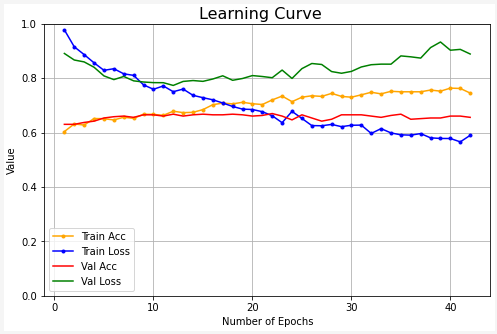


Validation set
loss: 0.8023753762245178
accuracy: 0.6705607771873474


In [ ]:
# Run CNN Model
tf.random.set_seed(seed_value)

history_cnn, model_cnn_ = model_run (actfn, 100, batch_size, model_cnn())
plot_history(history_cnn) 
print()
model_evalulate(model_cnn_)

- LSTM : Validation set  - loss: 0.7753225564956665, accuracy: 0.6845794320106506

- CNN : Validation set  - loss: 0.8023753762245178 ,accuracy: 0.6705607771873474

- LSTM Model has a greater accuracy and lower loss than CNN model , so i will optimise LSTM Model further



### Optimise LSTM further

- #1 Batch size and Number of Epoch

In [ ]:
#batch size and epoch
from keras.wrappers.scikit_learn import KerasClassifier

# create model
model = KerasClassifier(build_fn= model_lstm, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 32, 64, 80, 128]
epochs = [20, 30, 50]

param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.693799 using {'batch_size': 128, 'epochs': 50}
0.689710 (0.017549) with: {'batch_size': 10, 'epochs': 20}
0.692623 (0.008614) with: {'batch_size': 10, 'epochs': 30}
0.675061 (0.004071) with: {'batch_size': 10, 'epochs': 50}
0.685020 (0.010882) with: {'batch_size': 20, 'epochs': 20}
0.685609 (0.014705) with: {'batch_size': 20, 'epochs': 30}
0.683845 (0.005510) with: {'batch_size': 20, 'epochs': 50}
0.690880 (0.019184) with: {'batch_size': 32, 'epochs': 20}
0.690878 (0.013417) with: {'batch_size': 32, 'epochs': 30}
0.680927 (0.017268) with: {'batch_size': 32, 'epochs': 50}
0.686196 (0.016850) with: {'batch_size': 64, 'epochs': 20}
0.689119 (0.012681) with: {'batch_size': 64, 'epochs': 30}
0.682092 (0.011243) with: {'batch_size': 64, 'epochs': 50}
0.680919 (0.007677) with: {'batch_size': 80, 'epochs': 20}
0.685606 (0.010935) with: {'batch_size': 80, 'epochs': 30}
0.682673 (0.006925) with: {'batch_size': 80, 'epochs': 50}
0.668633 (0.018223) with: {'batch_size': 128, 'epochs': 20}


In [ ]:
# Best: 0.693799 using {'batch_size': 128, 'epochs': 50}
# I will use this batch size and epoch for further tuning of optimizer

- #2. Optimizer

In [ ]:
# function to build the model 
def model_lstm_act(optimizer = 'RMSprop'):
    
    model = Sequential()
    
    #create embedding layer
    model.add(Embedding(max_features, embedding_dim, trainable = False ,embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)))  

    model.add(layers.Bidirectional(layers.LSTM(20, dropout=0.5,activation='tanh')))

    model.add(Dense(10, activation='relu'))

    # final dense layer
    model.add(Dense(3,activation = 'softmax')) 
    
    # compile the model
    model.compile(loss = 'categorical_crossentropy',    
                 optimizer = optimizer    ,  
                 metrics = ['accuracy']) 

    return model

In [ ]:
# create model
model = KerasClassifier(build_fn = model_lstm_act, epochs=50, batch_size=128, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

grid_result = grid.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.693806 using {'optimizer': 'Adam'}
0.632338 (0.024118) with: {'optimizer': 'SGD'}
0.691464 (0.015207) with: {'optimizer': 'RMSprop'}
0.627652 (0.021391) with: {'optimizer': 'Adagrad'}
0.356417 (0.170014) with: {'optimizer': 'Adadelta'}
0.693806 (0.014246) with: {'optimizer': 'Adam'}
0.665124 (0.023388) with: {'optimizer': 'Adamax'}
0.683848 (0.008458) with: {'optimizer': 'Nadam'}


In [ ]:
# Best: 0.693806 using {'optimizer': 'Adam'}

- #3. Number of layers in BiLSTM and hiddensize in Dense layer

In [ ]:
# function to build the model with given no. of layers
def model_lstm_layers(no_layers_l, no_layers_d):
    
    model = Sequential()
    
    #create embedding layer
    model.add(Embedding(max_features, embedding_dim, trainable = False ,embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)))  

    # Bidirectional LSTM Layer
    model.add(layers.Bidirectional(layers.LSTM(no_layers_l, dropout=0.5,activation='tanh')))

    # dense layer
    model.add(Dense(no_layers_d, activation='relu'))

    # final dense layer
    model.add(Dense(3,activation = 'softmax')) 
    
    # compile the model
    model.compile(loss = 'categorical_crossentropy',    
                 optimizer = 'adam'     ,   
                 metrics = ['accuracy']) 

    return model

In [ ]:
# lstm layers
tf.random.set_seed(seed_value)

lstm_layers = [2, 5, 10, 15, 20, 25, 30]

for no_layers in lstm_layers:

  model = model_lstm_layers(no_layers, 10)

  es = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1 ,patience= 20, restore_best_weights = True  ) 
  history = model.fit(x_train,y_train, batch_size = 128, epochs = 60 ,validation_data=(x_valid,y_valid),callbacks=[es], verbose = 0)   # fit the model

  print("-------------------------")
  print("no_layers: ", no_layers)
  model_evalulate(model)
  print("-------------------------")
  print()

Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
-------------------------
no_layers:  2
Validation set
loss: 1.0014516115188599
accuracy: 0.6308411359786987
-------------------------

-------------------------
no_layers:  5
Validation set
loss: 0.7586606740951538
accuracy: 0.6705607771873474
-------------------------

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
-------------------------
no_layers:  10
Validation set
loss: 0.8013831973075867
accuracy: 0.6752336621284485
-------------------------

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
-------------------------
no_layers:  15
Validation set
loss: 0.7887979745864868
accuracy: 0.672897219657898
-------------------------

Restoring model weights from the end of the best epoch.
Epoch 00052: early stopping
-------------------------
no_layers:  20
Validation set
loss: 0.7647894620895386
accuracy: 0.6845794320106506
---------

In [ ]:
# Best- no_layers:  20 , loss: 0.7647894620895386, accuracy: 0.6845794320106506

In [ ]:
# Dense Layer size optimisation

tf.random.set_seed(seed_value)
dense_layers = [6,9,10,12,16]

for no_layers in dense_layers:

  model = model_lstm_layers( 20 , no_layers)

  es = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1 ,patience= 20, restore_best_weights = True  ) # loss - 7, 'min' restore_best_weights = True 
  history = model.fit(x_train,y_train, batch_size = 128, epochs = 60 ,validation_data=(x_valid,y_valid),callbacks=[es], verbose = 0)   # fit the model

  print("-------------------------")
  print("no_layers: ", no_layers)
  model_evalulate(model)
  print("-------------------------")
  print() 

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
-------------------------
no_layers:  6
Validation set
loss: 0.7835257649421692
accuracy: 0.6705607771873474
-------------------------

-------------------------
no_layers:  9
Validation set
loss: 0.8408368825912476
accuracy: 0.6682242751121521
-------------------------

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
-------------------------
no_layers:  10
Validation set
loss: 0.7996227145195007
accuracy: 0.677570104598999
-------------------------

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
-------------------------
no_layers:  12
Validation set
loss: 0.7715784907341003
accuracy: 0.677570104598999
-------------------------

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
-------------------------
no_layers:  16
Validation set
loss: 0.796851634979248
accuracy: 0.672897219657898
------------

In [ ]:
# Best size for dense layer- no_layers:  10, loss: 0.7996227145195007 , accuracy: 0.677570104598999

### Final Model


In [ ]:
# function to build the model 
def model_lstm_final():
    
    model = Sequential()
    
    #create embedding layer
    model.add(Embedding(max_features, embedding_dim, trainable = False ,embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix)))  

    # Bidirectional LSTM Layer
    model.add(layers.Bidirectional(layers.LSTM(20 , dropout=0.5,activation='tanh')))

    # dense layer
    model.add(Dense(10 , activation='relu'))

    # final dense layer
    model.add(Dense(3,activation = 'softmax'))
    
    # compile the model
    model.compile(loss = 'categorical_crossentropy',    
                 optimizer = 'adam' ,   
                 metrics = ['accuracy']) 

    return model

Epoch 1/60
14/14 [==============================] - 7s 109ms/step - loss: 1.0868 - accuracy: 0.2743 - val_loss: 1.0283 - val_accuracy: 0.2453
Epoch 2/60
14/14 [==============================] - 0s 15ms/step - loss: 1.0198 - accuracy: 0.3455 - val_loss: 0.9923 - val_accuracy: 0.6051
Epoch 3/60
14/14 [==============================] - 0s 17ms/step - loss: 0.9701 - accuracy: 0.6161 - val_loss: 0.9242 - val_accuracy: 0.6308
Epoch 4/60
14/14 [==============================] - 0s 15ms/step - loss: 0.9035 - accuracy: 0.6356 - val_loss: 0.8808 - val_accuracy: 0.6308
Epoch 5/60
14/14 [==============================] - 0s 17ms/step - loss: 0.8798 - accuracy: 0.6272 - val_loss: 0.8745 - val_accuracy: 0.6308
Epoch 6/60
14/14 [==============================] - 0s 15ms/step - loss: 0.8610 - accuracy: 0.6234 - val_loss: 0.8549 - val_accuracy: 0.6308
Epoch 7/60
14/14 [==============================] - 0s 16ms/step - loss: 0.8242 - accuracy: 0.6517 - val_loss: 0.8398 - val_accuracy: 0.6285
Epoch 8/60
1

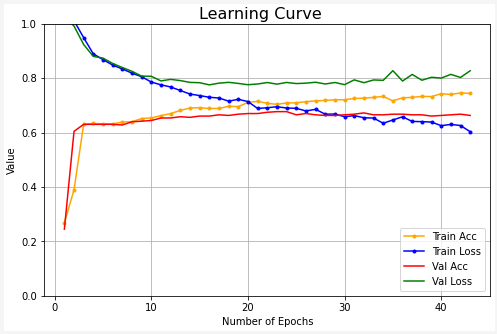


Validation set
loss: 0.7787066102027893
accuracy: 0.677570104598999
Test set
loss: 0.6610619425773621
accuracy: 0.7424023151397705


In [ ]:
tf.random.set_seed(seed_value)

history_final, model_final = model_run (actfn, 60, 128,  model_lstm_final())
plot_history(history_final) 

print()
model_evalulate(model_final)
model_evalulate_test(model_final)

In [ ]:
# Final Result

# Validation set
# loss: 0.7787066102027893
# accuracy: 0.677570104598999

# Test set
# loss: 0.6610619425773621
# accuracy: 0.7424023151397705

In [ ]:
y_pred =  model_final.predict(x_testing)
y_pred

array([[0.16351214, 0.15501368, 0.6814742 ],
       [0.34145004, 0.18301876, 0.4755312 ],
       [0.0317125 , 0.01569882, 0.9525886 ],
       ...,
       [0.29577914, 0.23795865, 0.46626225],
       [0.1256233 , 0.15146515, 0.7229116 ],
       [0.15743099, 0.19474217, 0.64782685]], dtype=float32)

In [ ]:
# confusion matrix
y_pred1 = y_pred.round()
cm = confusion_matrix(y_test.argmax(axis=1), y_pred1.argmax(axis=1))
print(cm)

[[ 65   1  50]
 [ 34   3  59]
 [ 67   1 411]]


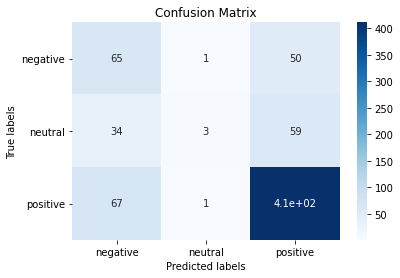

In [ ]:
# plot confusion  matrix
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ "negative", "neutral","positive"]);
ax.yaxis.set_ticklabels(["negative", "neutral","positive"],rotation = 0);

In [ ]:
# classification_report
report = metrics.classification_report(y_test.argmax(axis=1), y_pred1.argmax(axis=1) ,target_names=["negative", "neutral","positive"],labels = [0,1,2])
print(report)

              precision    recall  f1-score   support

    negative       0.39      0.56      0.46       116
     neutral       0.60      0.03      0.06        96
    positive       0.79      0.86      0.82       479

    accuracy                           0.69       691
   macro avg       0.59      0.48      0.45       691
weighted avg       0.70      0.69      0.66       691

